<a href="https://colab.research.google.com/github/thaCripple/SkinLesionClassifier_v2/blob/main/slc_v2_model_selection_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run experiments on several models to test their performance on a portion of the dataset

Models I want to test:

* EffNetB0,
* EffNetB1V2,
* EffNetB2,
* maxvit_t (rooting for you after reading the paper!)

I want to evaluate the accuracy after a few epochs (of secondary priority honestly, this is for fun and learning!) and (mostly) training times.

Originally I wanted this to be a practice exercise in using Tensorboard, but sadly I can't get it to work with Colab :( I couldn't find a solution online either, so instead it will be practice of pandas Dataframes with multi-index :D



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import json
import random
import os
import time

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torchmetrics

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
IMGS_ROOT = Path("/content/drive/MyDrive/skin_lesions")
train_imgs_dir = IMGS_ROOT / "train"
train_metadata = Path("/content/drive/MyDrive/skin_lesion_classifier_v2/train_metadata.csv")
test_imgs_dir = IMGS_ROOT / "test"
test_metadata = Path("/content/drive/MyDrive/skin_lesion_classifier_v2/test_metadata.csv")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display some images

In [ ]:
train_imgs_list = list(train_imgs_dir.glob("*/*.jpg")) + list(train_imgs_dir.glob("*/*.png"))
test_imgs_list = list(test_imgs_dir.glob("*/*.jpg")) + list(test_imgs_dir.glob("*/*.png"))

In [ ]:
len(train_imgs_list)

23265

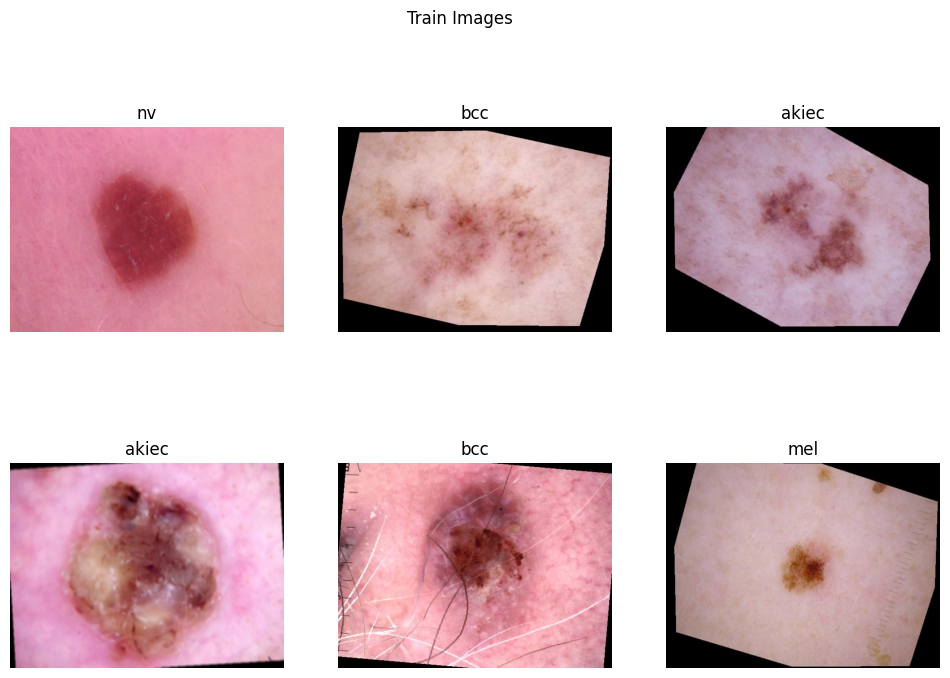

In [ ]:
cols = 3
rows = 2
num_imgs = len(train_imgs_list)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))

for i in range(rows*cols):
  idx = random.randint(0, num_imgs-1)
  img_path = train_imgs_list[idx]
  img = Image.open(img_path)
  label = img_path.parent.name
  axis = ax.flatten()[i]

  axis.imshow(img)
  axis.set_title(label)
  axis.axis(False)

fig.suptitle(t="Train Images")
fig.show()

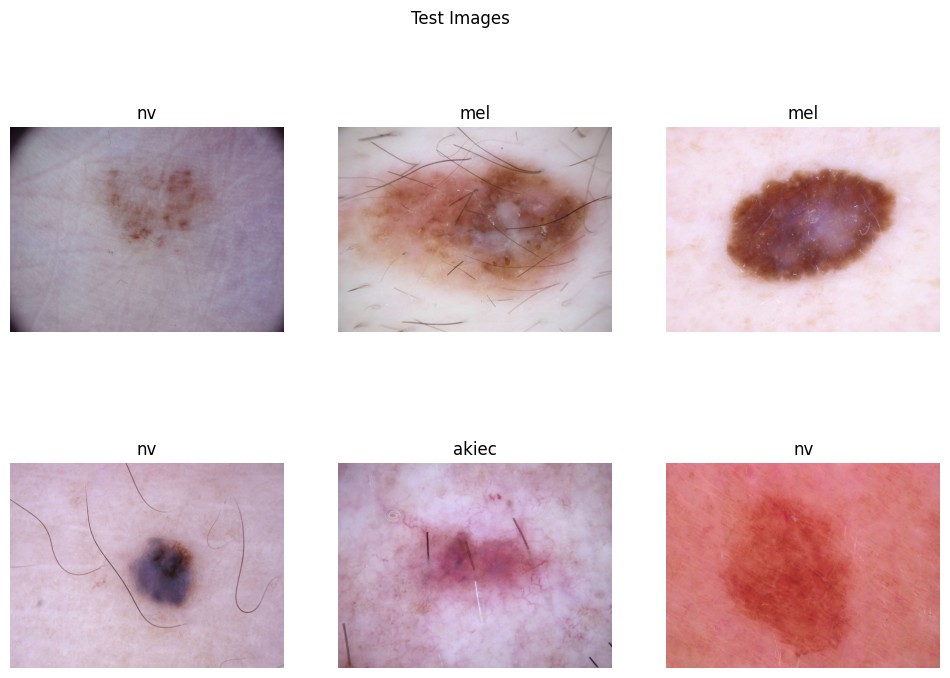

In [ ]:
cols = 3
rows = 2
num_imgs = len(test_imgs_list)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))

for i in range(rows*cols):
  idx = random.randint(0, num_imgs-1)
  img_path = test_imgs_list[idx]
  img = Image.open(img_path)
  label = img_path.parent.name
  axis = ax.flatten()[i]

  axis.imshow(img)
  axis.set_title(label)
  axis.axis(False)

fig.suptitle(t="Test Images")
fig.show()

# Create Datasets suitable for each model

## Collate all the models

In [ ]:
class ModelCandidate:
  """
  Holds model specific information and data used in the experiments.

  # Parameters:
    name: Name of the model for ease of identification
  """
  def __init__(self, name:str):
    self.name = name
    self.model = None
    self.transforms = None
    self.train_ds = None
    self.train_dl = None
    self.test_ds = None
    self.test_dl = None
    self.loss_fn = None
    self.optimizer = None

In [ ]:
models = []
effnet_b0 = ModelCandidate("effnet_b0")
models.append(effnet_b0)
effnet_b1 = ModelCandidate("effnet_b1")
models.append(effnet_b1)
effnet_b2 = ModelCandidate("effnet_b2")
models.append(effnet_b2)
maxvit = ModelCandidate("maxvit")
models.append(maxvit)
models

## Assign model specific transforms

In [ ]:
effnet_b0.transforms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
effnet_b1.transforms = torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V2.transforms()
effnet_b2.transforms = torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1.transforms()
maxvit.transforms = torchvision.models.MaxVit_T_Weights.IMAGENET1K_V1.transforms()

## Download the aux functions we prepared earlier

In [ ]:
!git clone --filter=blob:none --depth 1 --no-checkout "https://github.com/thaCripple/SkinLesionClassifier_v2.git"
%cd "/content/SkinLesionClassifier_v2"
!git sparse-checkout set --cone
!git checkout main
!git sparse-checkout set "auxiliaries"
%cd "/content"

fatal: destination path 'SkinLesionClassifier_v2' already exists and is not an empty directory.
/content/SkinLesionClassifier_v2
Already on 'main'
Your branch is up to date with 'origin/main'.
/content


In [ ]:
from SkinLesionClassifier_v2.auxiliaries.auxiliaries import CustomImageDataset

## Create and store dataloaders
For the experiment we will fine-tune the models on 15% of the training data (~3.5k images) and test on the entire testing subset

In [ ]:
BATCH_SIZE = 32
WORKERS = os.cpu_count()

In [ ]:
for model in models:
  model.train_ds = CustomImageDataset(root_dir=IMGS_ROOT, metadata=train_metadata, subset="train", original_only=False, portion=.15, transform=model.transforms)
  model.train_dl = torch.utils.data.DataLoader(dataset=model.train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
  model.test_ds = CustomImageDataset(root_dir=IMGS_ROOT, metadata=test_metadata, subset="test", original_only=False, transform=model.transforms)
  model.test_dl = torch.utils.data.DataLoader(dataset=model.test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

## Visualization to check if it works

In [ ]:
cols = 3
rows = len(models)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))

for i in range(rows):
  current_model = models[i]

  # Show 2 random train imgs
  train_imgs_batch, train_imgs_label = next(iter(current_model.train_dl))
  # Move the channel dimension to the last position (H, W, C)
  train_img1 = torch.movedim(input=train_imgs_batch[0], source=0, destination=-1)
  train_img1_lbl = current_model.train_ds.classes[train_imgs_label[0]]
  train_img2 = torch.movedim(input=train_imgs_batch[1], source=0, destination=-1)
  train_img2_lbl = current_model.train_ds.classes[train_imgs_label[1]]

  ax[i,0].imshow(train_img1)
  # Can't use ax.axis(False) because I still want to show the model's name as a y axis label
  ax[i,0].yaxis.set_ticks([])
  ax[i,0].xaxis.set_ticks([])
  ax[i,0].set(title=train_img1_lbl)
  ax[i,0].set_ylabel(current_model.name, fontsize="x-large")

  ax[i,1].imshow(train_img2)
  ax[i,1].set_title(train_img2_lbl)
  ax[i,1].axis(False)

  # Show a random test img
  test_imgs_batch, test_imgs_label = next(iter(current_model.test_dl))
  test_idx = random.randint(0, BATCH_SIZE-1)
  test_img1 = torch.movedim(input=test_imgs_batch[test_idx], source=0, destination=-1)
  test_img1_lbl = current_model.test_ds.classes[test_imgs_label[test_idx]]
  ax[i,2].imshow(test_img1)
  ax[i,2].set_title(test_img1_lbl)
  ax[i,2].axis(False)

fig.set(layout_engine="compressed")
fig.show()

# Instantiate the models
1. Download the base model from PyTorch
2. Overwrite the classification block
3. Create a loss function
  * Since each model has its own partial dataset the class counts might be different? For safety we will calculate class weights for each model separately

## Efficientnet_B0

### Get the base model

In [ ]:
effnet_b0.model = torchvision.models.efficientnet_b0(weights='DEFAULT')

In [ ]:
effnet_b0.model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
head_in_features = effnet_b0.model.classifier[-1].in_features
head_in_features

1280

### Overwrite the Linear layer

In [ ]:
effnet_b0.train_ds.classes.shape

(7,)

In [ ]:
effnet_b0.model.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=True)
effnet_b0.model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

### Define the loss function and assign class weights

In [ ]:
effnet_b0.train_ds.metadata_df

,image_name,class_name,original
14944,ISIC_0034182.jpg,nv,True
14945,ISIC_0034179.jpg,nv,True
14946,ISIC_0034171.jpg,nv,True
14947,ISIC_0034178.jpg,nv,True
14948,ISIC_0034174.jpg,nv,True
...,...,...,...
9262,ISIC_0031827.jpg,df,True
9263,ISIC_0032114.jpg,df,True
9264,ISIC_0032138.jpg,df,True
9265,ISIC_0032247.jpg,df,True


In [ ]:
y_train = effnet_b0.train_ds.metadata_df['class_name'].to_numpy()
y_train.shape

(3487,)

In [ ]:
unique_classes = np.unique(y_train)
unique_classes

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

Let's create a function

In [ ]:
def create_loss_fn(model:ModelCandidate, verbose:bool=False, device=device)->nn.CrossEntropyLoss:
  """
  Calculates class weights for the model specific dataset and returns a loss function with the weights applied

  # Parameters
  model: instance of the ModelCandidate class
  verbose: print calculated weights so I can make sure they make sense

  # Returns
  nn.CrossEntropyLoss with class weights applied
  """
  y_train = model.train_ds.metadata_df['class_name'].to_numpy()
  unique_classes = np.unique(y_train)
  class_weights_arr = compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_train)
  class_weights = torch.from_numpy(class_weights_arr).to(dtype=torch.float32)
  if verbose:
    print(model.name)
    print(class_weights)
    print(model.train_ds.classes)
    print(model.train_ds.metadata_df['class_name'].value_counts())

  return nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
create_loss_fn(model=effnet_b0, verbose=True)

effnet_b0
tensor([2.2439, 1.3685, 0.6314, 5.2436, 0.6469, 0.4366, 4.6995])
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
class_name
nv       1141
bkl       789
mel       770
bcc       364
akiec     222
vasc      106
df         95
Name: count, dtype: int64


CrossEntropyLoss()

Looks good. Let's go!

In [ ]:
effnet_b0.loss_fn = create_loss_fn(model=effnet_b0)
effnet_b0.loss_fn.weight

tensor([2.2439, 1.3685, 0.6314, 5.2436, 0.6469, 0.4366, 4.6995])

## Define the optimizer

[reference](https://arxiv.org/pdf/1905.11946)

In [ ]:
effnet_b0.optimizer = torch.optim.RMSprop(params=effnet_b0.model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=1e-5, momentum=0.9)

## Efficientnet_B1

### Get the base model

In [ ]:
effnet_b1.model = torchvision.models.efficientnet_b1(weights='DEFAULT')

In [ ]:
effnet_b1.model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
head_in_features = effnet_b1.model.classifier[-1].in_features
head_in_features

1280

### Overwrite the Linear layer

In [ ]:
effnet_b1.model.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=True)
effnet_b1.model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

### Assign the loss function

In [ ]:
effnet_b1.loss_fn = create_loss_fn(model=effnet_b1)
effnet_b1.loss_fn

CrossEntropyLoss()

## Define the optimizer

[reference](https://arxiv.org/pdf/1905.11946)

In [ ]:
effnet_b1.optimizer = torch.optim.RMSprop(params=effnet_b1.model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=1e-5, momentum=0.9)

## Efficientnet_B2

### Get the base model

In [ ]:
effnet_b2.model = torchvision.models.efficientnet_b2(weights='DEFAULT')

In [ ]:
effnet_b2.model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
head_in_features = effnet_b2.model.classifier[-1].in_features
head_in_features

1408

### Overwrite the Linear layer

In [ ]:
effnet_b2.model.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=True)
effnet_b2.model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=7, bias=True)
)

### Assign the loss function

In [ ]:
effnet_b2.loss_fn = create_loss_fn(model=effnet_b2)
effnet_b2.loss_fn

CrossEntropyLoss()

## Define the optimizer

[reference](https://arxiv.org/pdf/1905.11946)

In [ ]:
effnet_b2.optimizer = torch.optim.RMSprop(params=effnet_b2.model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=1e-5, momentum=0.9)

## MaxVit_t

### Get the base model

In [ ]:
maxvit.model = torchvision.models.maxvit_t(weights='DEFAULT')

In [ ]:
maxvit.model.classifier

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Tanh()
  (5): Linear(in_features=512, out_features=1000, bias=False)
)

In [ ]:
head_in_features = maxvit.model.classifier[-1].in_features
head_in_features

512

### Overwrite the Linear layer

In [ ]:
maxvit.model.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=False)
maxvit.model.classifier

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Tanh()
  (5): Linear(in_features=512, out_features=7, bias=False)
)

### Assign the loss function

In [ ]:
maxvit.loss_fn = create_loss_fn(model=maxvit)
maxvit.loss_fn

CrossEntropyLoss()

## Define the optimizer

[reference](https://arxiv.org/pdf/2204.01697)

In [ ]:
maxvit.optimizer = torch.optim.AdamW(params=maxvit.model.parameters(), lr=5e-6, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-8)

# Define the training functions

## train_step function

In [ ]:
def train_step(model:nn.Module, train_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.train()
  for x_batch, y_batch in train_dl:
    x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    total_epoch_loss += loss.item()

    accuracy = accuracy_fn(preds=logits, target=y_batch)
    total_epoch_accuracy += accuracy.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## test_step function

In [ ]:
def test_step(model:nn.Module, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
              accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(test_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)
      total_epoch_loss += loss.item()

      accuracy = accuracy_fn(preds=logits, target=y_batch)
      total_epoch_accuracy += accuracy.item()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## training loop function

In [ ]:
def train_model(model:nn.Module, train_dl:torch.utils.data.DataLoader, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device, epochs:int=1, save_path:Path|None=None)->dict:

  train_metrics = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []}

  for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch}/{epochs-1}")

    train_loss, train_accuracy = train_step(model=model, train_dl=train_dl, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_loss, test_accuracy = test_step(model=model, test_dl=test_dl, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

    train_metrics["train_loss"].append(train_loss)
    train_metrics["train_accuracy"].append(train_accuracy)
    train_metrics["test_loss"].append(test_loss)
    train_metrics["test_accuracy"].append(test_accuracy)

    print(f"Train loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}")
    print(f"Test loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.2f}")
    print("-"*80)

    if save_path is not None:
      torch.save(obj=model, f=save_path)
      print(f"Model saved after epoch {epoch}")

    print(f"Time taken {time.time() - epoch_start_time}s", end="\n\n")

  return train_metrics

# Set-up the experiment

In [ ]:
EPOCHS = 10
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=7, average="micro").to(device=device)

In [ ]:
experiment_history = {}

In [ ]:
for model in models:
  print(f"##### Current model: {model.name} #####")
  model.loss_fn = model.loss_fn.to(device=device)
  model_compiled = torch.compile(model.model.to(device=device))
  experiment_history[model.name] = train_model(model=model_compiled,
                                               train_dl=model.train_dl,
                                               test_dl=model.test_dl,
                                               loss_fn=model.loss_fn,
                                               optimizer=model.optimizer,
                                               accuracy_fn=accuracy_fn,
                                               device=device,
                                               epochs=EPOCHS)

Epoch 0/9


W0403 11:59:20.111000 4737 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Train loss: 17.220 | Train Accuracy: 0.16
Test loss: 1.935 | Test Accuracy: 0.59
--------------------------------------------------------------------------------
Time taken 1204.0199520587921s

Epoch 1/9
Train loss: 6.828 | Train Accuracy: 0.19
Test loss: 59.156 | Test Accuracy: 0.16
--------------------------------------------------------------------------------
Time taken 70.49045467376709s

Epoch 2/9
Train loss: 7.039 | Train Accuracy: 0.19
Test loss: 2.745 | Test Accuracy: 0.17
--------------------------------------------------------------------------------
Time taken 70.86283683776855s

Epoch 3/9
Train loss: 3.589 | Train Accuracy: 0.22
Test loss: 2.643 | Test Accuracy: 0.20
--------------------------------------------------------------------------------
Time taken 70.36272192001343s

Epoch 4/9
Train loss: 3.636 | Train Accuracy: 0.20
Test loss: 23.037 | Test Accuracy: 0.07
--------------------------------------------------------------------------------
Time taken 72.8178191184997

# Save the experiment's history for later visualization and analysis

In [ ]:
with open(file=Path("/content/drive/MyDrive/skin_lesion_classifier_v2", "model_selection_experiment1.json"), mode="w") as hist_file:
  json.dump(obj=experiment_history, fp=hist_file)

NameError: name 'experiment_history' is not defined

In [ ]:
with open(file=Path("/content/drive/MyDrive/skin_lesion_classifier_v2", "model_selection_experiment1.json"), mode="r") as hist_file:
  experiment_history = json.load(hist_file)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
experiment_history

{'effnet_b0': {'train_loss': [17.220397258023603,
   6.827710960983136,
   7.03949937689195,
   3.5887750934023375,
   3.6356368567965447,
   3.2122297024508133,
   2.6389191894356263,
   2.264582930354897,
   1.9891382674558447,
   1.9567355847139971],
  'train_accuracy': [0.1591724622140237,
   0.1863902041671473,
   0.1861035069194409,
   0.21998927188575815,
   0.20359203902953263,
   0.20391572943521202,
   0.22255105053612945,
   0.2286086858959373,
   0.22970923343929675,
   0.2483260579612277],
  'test_loss': [1.9350375918050606,
   59.15557370831569,
   2.74468527858456,
   2.6433835700154305,
   23.036929816007614,
   2.3245151452720165,
   1.8235426992177963,
   1.5827800097564857,
   1.6123592307170231,
   1.7409393539031346],
  'test_accuracy': [0.5872395833333334,
   0.15950520833333334,
   0.16927083333333334,
   0.19791666666666666,
   0.07096354166666667,
   0.115234375,
   0.57421875,
   0.5911458333333334,
   0.365234375,
   0.322265625]},
 'effnet_b1': {'train_loss'

In [ ]:
hist_dfs = []
for model_name in experiment_history.keys():
  hist_dfs.append(pd.DataFrame(data=experiment_history.get(model_name)))

hist_df = pd.concat(objs=hist_dfs, axis=1, keys=list(experiment_history.keys()), names=["model", "metric"])
hist_df.index.name = "epoch"
hist_df

model   effnet_b0                                          effnet_b1  \
metric train_loss train_accuracy  test_loss test_accuracy train_loss   
epoch                                                                  
0       17.220397       0.159172   1.935038      0.587240  19.949524   
1        6.827711       0.186390  59.155574      0.159505   4.048972   
2        7.039499       0.186104   2.744685      0.169271   2.824847   
3        3.588775       0.219989   2.643384      0.197917   2.477931   
4        3.635637       0.203592  23.036930      0.070964   2.342990   
5        3.212230       0.203916   2.324515      0.115234   2.134402   
6        2.638919       0.222551   1.823543      0.574219   2.152252   
7        2.264583       0.228609   1.582780      0.591146   2.215804   
8        1.989138       0.229709   1.612359      0.365234   2.042401   
9        1.956736       0.248326   1.740939      0.322266   2.617146   

model                                             effnet_b2                 \
metric train_accuracy    test_loss test_accuracy train_loss train_accuracy   
epoch                                                                        
0            0.151681    17.918259      0.079427  25.131475       0.154863   
1            0.187888  6194.614146      0.555711  11.750044       0.151987   
2            0.232280  1269.017321      0.392485   9.248348       0.173748   
3            0.223929    22.216496      0.136719   6.152661       0.157138   
4            0.232872     2.887453      0.288411   6.031496       0.167755   
5            0.240336     2.688526      0.028646   4.094780       0.182700   
6            0.221654     1.605338      0.484375   3.400077       0.162298   
7            0.260941    18.639335      0.288411   2.710229       0.186399   
8            0.222505     4.163915      0.111328   3.783358       0.167524   
9            0.179482     1.997725      0.279297   2.901448       0.156037   

model                                 maxvit                           \
metric    test_loss test_accuracy train_loss train_accuracy test_loss   
epoch                                                                   
0       2178.623875      0.096354   1.934135       0.173803  1.985231   
1          4.367147      0.141276   1.859440       0.261597  1.833216   
2         21.618496      0.226562   1.783901       0.347579  1.736200   
3          2.097863      0.047526   1.695765       0.418116  1.640953   
4          2.530053      0.126302   1.598874       0.490715  1.545504   
5          2.664533      0.060547   1.506980       0.535402  1.442251   
6          3.177741      0.065104   1.409693       0.573875  1.341391   
7          2.679767      0.097656   1.316493       0.601953  1.252389   
8          6.165828      0.577474   1.233968       0.628931  1.160003   
9          1.851739      0.141927   1.148943       0.650146  1.097451   

model                 
metric test_accuracy  
epoch                 
0           0.124535  
1           0.299851  
2           0.443731  
3           0.520275  
4           0.565569  
5           0.607236  
6           0.636533  
7           0.664900  
8           0.687035  
9           0.694568

In [ ]:
test_acc_df = hist_df.xs(key="test_accuracy", axis=1, level=1)
test_acc_df.max(axis=0).sort_values(axis=0, ascending=False)

,0
model,
maxvit,0.694568
effnet_b0,0.591146
effnet_b2,0.577474
effnet_b1,0.555711


In [ ]:
hist_df.xs(key="test_loss", axis=1, level=1).min(axis=0).sort_values(axis=0, ascending=True)

,0
model,
maxvit,1.097451
effnet_b0,1.582780
effnet_b1,1.605338
effnet_b2,1.851739


In [ ]:
hist_df[('effnet_b0', "test_loss")]

,effnet_b0
,test_loss
epoch,
0,1.935038
1,59.155574
2,2.744685
3,2.643384
4,23.036930
5,2.324515
6,1.823543
7,1.582780


In [ ]:
hist_df.keys().levels

Index(['effnet_b0', 'effnet_b1', 'effnet_b2', 'maxvit'], dtype='object', name='model')

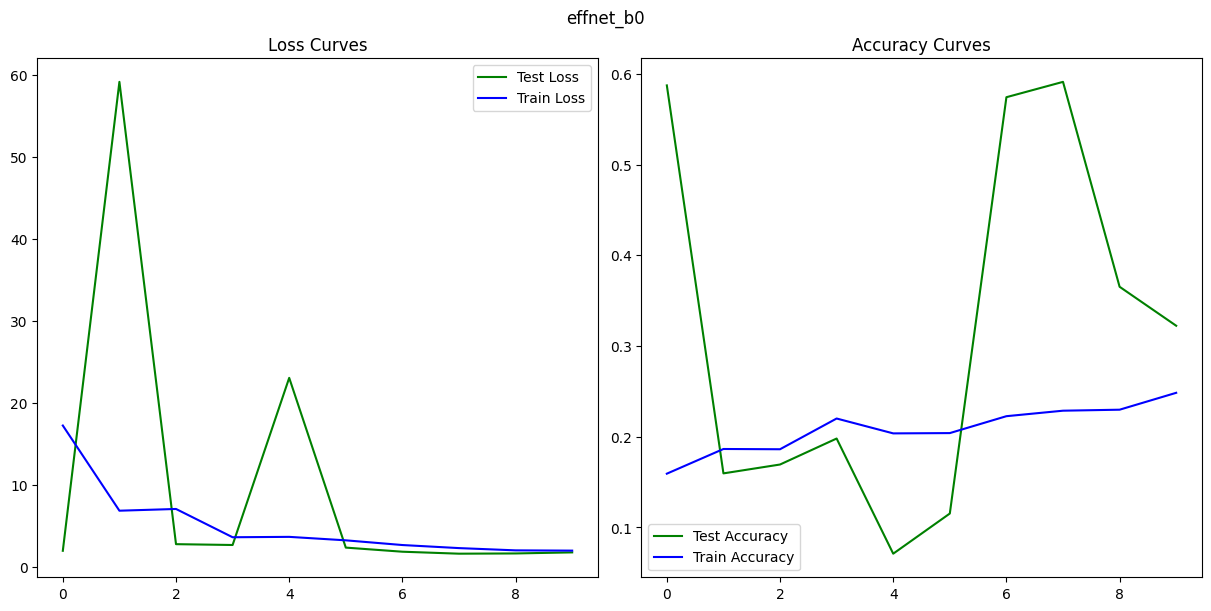

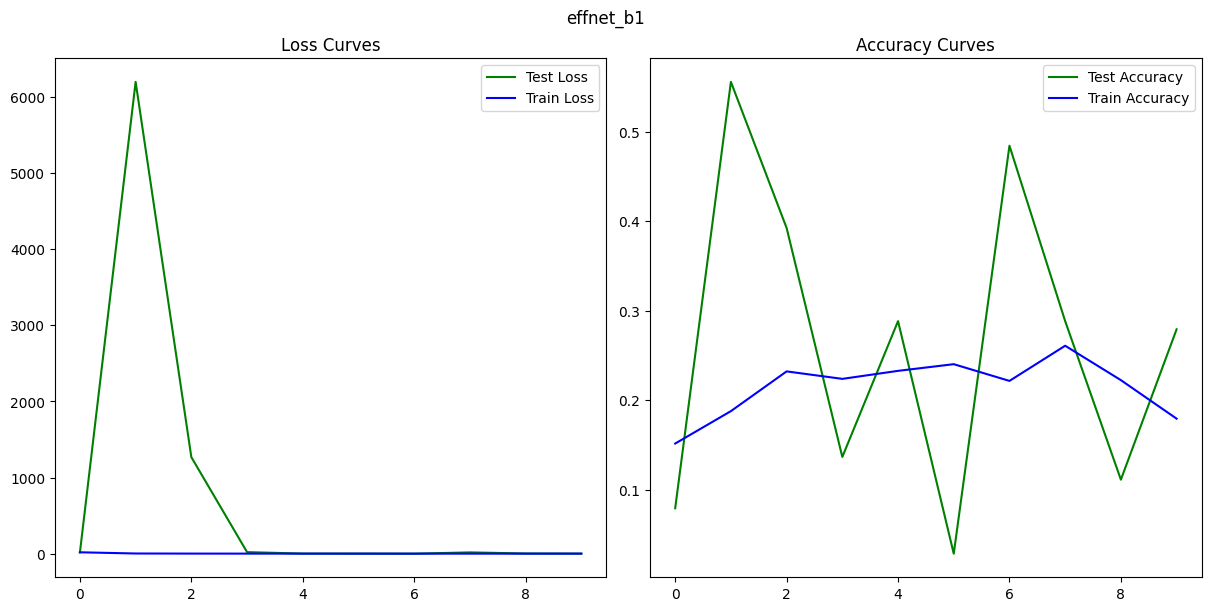

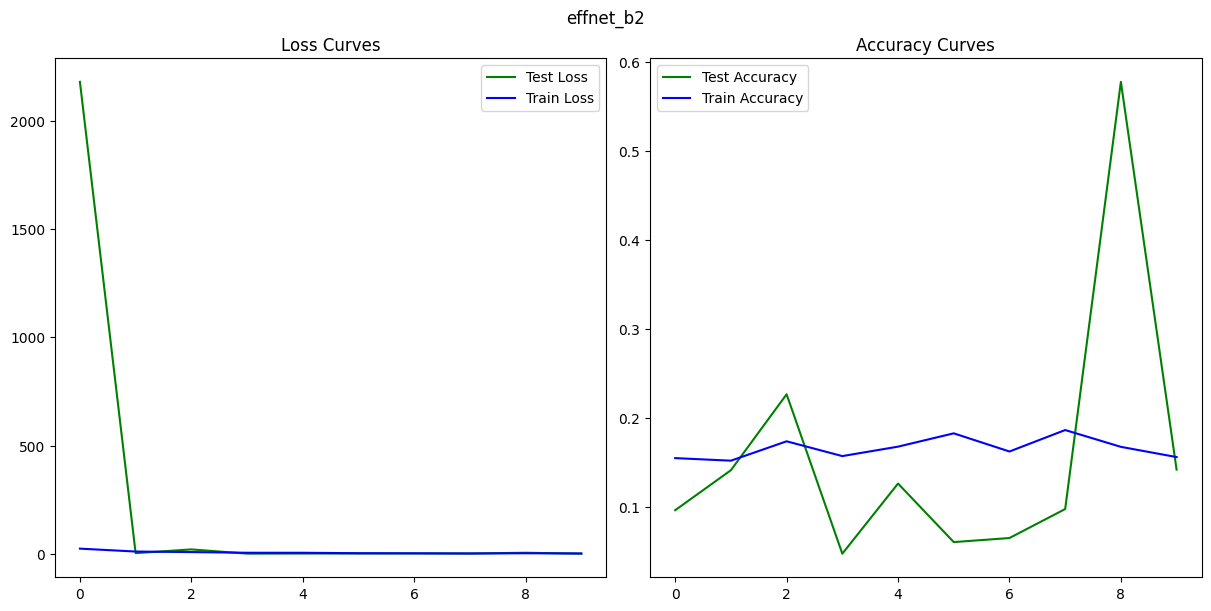

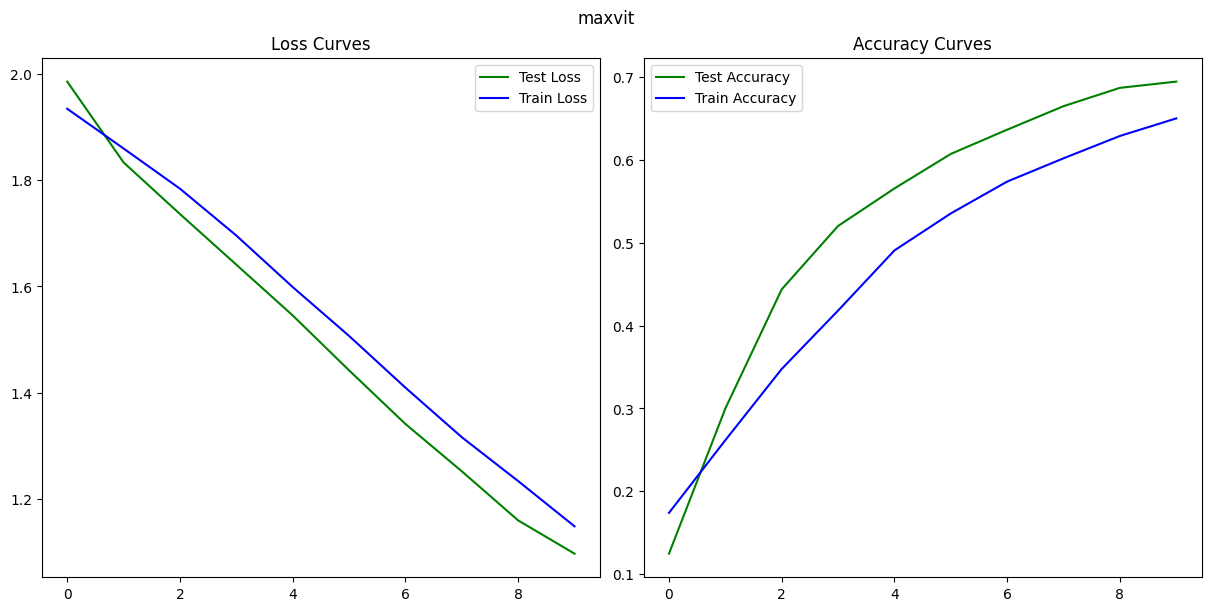

In [ ]:
for i in range(4):
  model_name = hist_df.keys().levels[0][i]
  fig, ax = plt.subplots(ncols=2, figsize=(12,6))
  ax[0].plot(hist_df.index, hist_df[(model_name, "test_loss")], color="green", label="Test Loss")
  ax[0].plot(hist_df.index, hist_df[(model_name, "train_loss")], color="blue", label="Train Loss")
  ax[0].legend()
  ax[0].set_title("Loss Curves")

  ax[1].plot(hist_df.index, hist_df[(model_name, "test_accuracy")], color="green", label="Test Accuracy")
  ax[1].plot(hist_df.index, hist_df[(model_name, "train_accuracy")], color="blue", label="Train Accuracy")
  ax[1].legend()
  ax[1].set_title("Accuracy Curves")
  fig.suptitle(model_name)
  fig.set_layout_engine("compressed")

# Conclusions

1. I messed up with the RMSProp optimizer for EfficientNet models. Messed up hard. Should have read about it before running the experimnets. I followed the efficientnet research paper, it isn't that old, but I should have stuck with Adam or AdamW as always.
  * Curiously enough the smallest efficient net (the B0) achieved better accuracy and loss than its bigger siblings; and they used the same broken optimizer 🤔